<h1 align="center">Diseño e Implementación de Modelo de Clasificación usando FC-DNN</h1>

El objetivo es clasificar a los individuos de una manera personalizada en una de las tres modalidades laborales existentes, según se adapte mejor a sus necesidades. A partir de las relaciones extraídas de cada una de las características de los empleados se obtendrán las predicciones de las dinámicas presencial, remoto o híbrido.

### 1. Importar Librerías:

In [1]:
# Manipulación y Procesamiento de datos
import numpy as np
import pandas as pd

# Aprendizaje automático (profundo)
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Visualización de datos
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Manejo de archivos
import xlsxwriter
import os

C:\Users\zorri\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\zorri\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### 2. Lectura del Dataset:

In [2]:
# Dataset inicial contiene las características con registros completos del modelo de regresión
df_inicial = pd.read_excel("Dataset_completo.xlsx")
df_inicial.head()

,id,Años de experiencia,Horas de trabajo semanales,Opinión actual de teletrabajo,Calificación trabajo remoto 100%,Aceptación del trabajo en remoto en su sector,Nivel de estrés,Frecuencia de actividad física,Efecto en productividad laboral del teletrabajo,Comunicación en remoto con compañeros,...,Consolidación del teletrabajo en el sector,Valoración general del teletrabajo,Productividad en actual trabajo,Satisfacción en actual trabajo,Nacionalidad,Sector laboral,Modalidad laboral actual,Condición de salud mental,Modalidad preferida,Cambios para sostenibilidad teletrabajo
0,1,1.5,8.0,2,2,3,B. Medio,D. 1 día a la semana,2,2,...,Sí,8,6,8,Española,Tecnología y Ciencia,Híbrido,Sin problema específico,Híbrido,No
1,2,20.0,48.0,2,2,3,B. Medio,D. 1 día a la semana,1,1,...,Sí,6,6,6,Española,Tecnología y Ciencia,Remoto,Burnout,Híbrido,Sí
2,3,2.0,30.0,3,3,3,C. Bajo,D. 1 día a la semana,2,2,...,No,8,6,7,Española,Tecnología y Ciencia,Híbrido,Sin problema específico,Híbrido,No
3,4,1.0,43.0,3,2,3,B. Medio,E. Rara vez,2,2,...,Sí,9,7,8,Española,Tecnología y Ciencia,Remoto,Sin problema específico,Híbrido,Sí
4,5,1.0,40.0,1,1,3,C. Bajo,D. 1 día a la semana,2,1,...,No,3,6,8,Española,Tecnología y Ciencia,Híbrido,Sin problema específico,Presencial 100%,Sí


In [3]:
df_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               365 non-null    int64  
 1   Años de experiencia                              365 non-null    float64
 2   Horas de trabajo semanales                       365 non-null    float64
 3   Opinión actual de teletrabajo                    365 non-null    int64  
 4   Calificación trabajo remoto 100%                 365 non-null    int64  
 5   Aceptación del trabajo en remoto en su sector    365 non-null    int64  
 6   Nivel de estrés                                  365 non-null    object 
 7   Frecuencia de actividad física                   365 non-null    object 
 8   Efecto en productividad laboral del teletrabajo  365 non-null    int64  
 9   Comunicación en remoto con compa

In [4]:
print(df_inicial.columns.tolist())

['id', 'Años de experiencia', 'Horas de trabajo semanales', 'Opinión actual de teletrabajo', 'Calificación trabajo remoto 100%', 'Aceptación del trabajo en remoto en su sector', 'Nivel de estrés', 'Frecuencia de actividad física', 'Efecto en productividad laboral del teletrabajo', 'Comunicación en remoto con compañeros', 'Efecto en bienestar del teletrabajo', 'Consolidación del teletrabajo en el sector', 'Valoración general del teletrabajo', 'Productividad en actual trabajo', 'Satisfacción en actual trabajo', 'Nacionalidad', 'Sector laboral', 'Modalidad laboral actual', 'Condición de salud mental', 'Modalidad preferida', 'Cambios para sostenibilidad teletrabajo']


### 3. Preprocesamiento de datos:

#### 3.1. Aplicación de reglas iniciales.

Para reducir la incertidumbre, si un trabajador se encuentra en una modalidad determinada y, además, su sector le otorga aceptación en la misma dinámica, entre otras relaciones, se asigna con certeza la modalidad correspondiente.


In [5]:
def aplicar_reglas(fila):
    # Presencial (etiqueta = 0)
    if (
        (fila["Modalidad laboral actual"] == "Presencial" and fila["Aceptación del trabajo en remoto en su sector"] == 0) or
        (fila["Modalidad laboral actual"] == "Presencial" and fila["Efecto en productividad laboral del teletrabajo"] == 1) or
        (fila["Modalidad laboral actual"] == "Presencial" and fila["Comunicación en remoto con compañeros"] == 1) or
        (fila["Modalidad laboral actual"] == "Presencial" and fila["Efecto en bienestar del teletrabajo"] == 1)
    ):
        return 0

    # Remoto (etiqueta = 1)
    if (
        (fila["Modalidad laboral actual"] == "Remoto" and fila["Aceptación del trabajo en remoto en su sector"] == 1) or
        (fila["Modalidad laboral actual"] == "Remoto" and fila["Efecto en productividad laboral del teletrabajo"] == 3) or
        (fila["Modalidad laboral actual"] == "Remoto" and fila["Comunicación en remoto con compañeros"] == 3) or
        (fila["Modalidad laboral actual"] == "Remoto" and fila["Efecto en bienestar del teletrabajo"] == 3) or
        (fila["Modalidad laboral actual"] == "Remoto" and fila["Calificación trabajo remoto 100%"] == 3) or
        (fila["Modalidad laboral actual"] == "Remoto" and fila["Opinión actual de teletrabajo"] == 3)
    ):
        return 1

    # Híbrido (etiqueta = 2)
    if (
        (fila["Modalidad laboral actual"] == "Híbrido" and fila["Efecto en productividad laboral del teletrabajo"] == 2) or
        (fila["Modalidad laboral actual"] == "Híbrido" and fila["Comunicación en remoto con compañeros"] == 2) or
        (fila["Modalidad laboral actual"] == "Híbrido" and fila["Efecto en bienestar del teletrabajo"] == 2)
    ):
        return 2

    # Si no se cumple ninguna condición, asigna -1
    return -1

In [6]:
# Aplicar reglas al dataset
df_inicial["Modalidad objetivo"] = df_inicial.apply(aplicar_reglas, axis=1)

# Obtener los valores únicos de la columna 'Modalidad objetivo'
reglas_inicialesUnicas = df_inicial['Modalidad objetivo'].unique()
print(reglas_inicialesUnicas)

[ 2  1 -1  0]


In [7]:
archivo_excel = 'Dataset Reglas iniciales.xlsx'

# Si el archivo ya existe, eliminarlo para poder reemplazarlo
if os.path.exists(archivo_excel):
    os.remove(archivo_excel)

# Exportar el DataFrame a un archivo Excel
df_inicial.to_excel(archivo_excel, index=False)
print("El archivo Excel se ha creado exitosamente, reemplazando el anterior.")

El archivo Excel se ha creado exitosamente, reemplazando el anterior.


#### 3.2. Transformación de las variables categóricas a numéricas.

Esta transformación es necesaria para que el modelo interprete e identifique patrones en los datos de manera correcta, ya que, al trabajar con datos categóricos no se pueden llevar a cabo cálculos matemáticos.

##### 3.2.1. LabelEncoder.

El método LabelEncoder asigna a cada categoría un valor numérico único, concretamente un valor entero que puede tomar de 0 a 9 dígitos. Además, se introduce un orden jerárquico clave en la transformación de las siguientes características: 'Nivel de estrés' y 'Frecuencia de actividad física'.

In [8]:
# Lista de columnas categóricas
columnas_categoricas_labelEncoding = ['Nivel de estrés', 'Frecuencia de actividad física', 'Opinión actual de teletrabajo', 
                                      'Comunicación en remoto con compañeros', 'Consolidación del teletrabajo en el sector']

# Diccionario para almacenar los LabelEncoders para cada columna y los mapeos de cada columna
label_encoders = {}
mapeo_clases_labelEncoding = {}

# Aplicar Labelencoder a cada columna categórica
for columna in columnas_categoricas_labelEncoding:
    le = LabelEncoder()
    df_inicial[columna] = le.fit_transform(df_inicial[columna])
    label_encoders[columna] = le # Guardar el codificador para usos posteriores
    # Guardar el mapeo con la categoría como clave y el número como valor
    mapeo_clases_labelEncoding[columna] = {class_name: index for index, class_name in enumerate(le.classes_)}
    
    # Invertir el mapeo: asignar números en orden inverso
    mapeo = {class_name: len(le.classes_) - 1 - index for index, class_name in enumerate(le.classes_)}
    mapeo_clases_labelEncoding[columna] = mapeo

    # Aplicar el mapeo invertido a la columna
    df_inicial[columna] = df_inicial[columna].map({v: k for k, v in mapeo.items()}).map(mapeo)
    
# Imprimir los mapeos de clases para cada columna
for columna, mapping in mapeo_clases_labelEncoding.items():
    print(f"\033[1m{columna}\033[0m: {mapping}")
    
# LabelEncoder info: https://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.LabelEncoder.html
# Bold text: https://www.kodeclik.com/how-to-bold-text-in-python/

Nivel de estrés: {'A. Alto': 3, 'B. Medio': 2, 'C. Bajo': 1, 'D. Ninguno': 0}
Frecuencia de actividad física: {'A. Diariamente': 4, 'B. 4 o 5 días a la semana': 3, 'C. 3 o 4 días a la semana': 2, 'D. 1 día a la semana': 1, 'E. Rara vez': 0}
Opinión actual de teletrabajo: {1: 2, 2: 1, 3: 0}
Comunicación en remoto con compañeros: {1: 2, 2: 1, 3: 0}
Consolidación del teletrabajo en el sector: {'No': 1, 'Sí': 0}


##### 3.2.2. One-Hot Encoding.

El método One-Hot Encoding asigna a cada categoría un valor binario único (0s y 1s). No se introduce un orden jerárquico, siendo crucial para que cada neurona pueda aprender de manera independiente.

In [9]:
# Lista de columnas categóricas
columnas_categoricas_onehotEncoding = [
    'Nacionalidad', 'Sector laboral', 
    'Modalidad laboral actual', 'Condición de salud mental', 
    'Modalidad preferida', 'Cambios para sostenibilidad teletrabajo'
]

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Transformar las columnas categóricas
encoded_data = onehot_encoder.fit_transform(df_inicial[columnas_categoricas_onehotEncoding])

# Obtener los nombres de las nuevas columnas usando get_feature_names_out
columnas_onehot = onehot_encoder.get_feature_names_out(columnas_categoricas_onehotEncoding)

# Crear un DataFrame con los datos codificados
df_encoded = pd.DataFrame(encoded_data, columns=columnas_onehot, index=df_inicial.index)

# Combinar el DataFrame codificado con el DataFrame original y eliminar las columnas originales
df_inicial = pd.concat([df_inicial.drop(columns=columnas_categoricas_onehotEncoding), df_encoded], axis=1)

print(f"Columnas creadas con One Hot Encoding: {list(df_encoded.columns)}")

Columnas creadas con One Hot Encoding: ['Nacionalidad_Alemana', 'Nacionalidad_Americana', 'Nacionalidad_Argentina', 'Nacionalidad_Boliviana', 'Nacionalidad_Brasileña', 'Nacionalidad_Chilena', 'Nacionalidad_Colombiana', 'Nacionalidad_Cubana', 'Nacionalidad_Dominicana', 'Nacionalidad_Ecuatoriana', 'Nacionalidad_Española', 'Nacionalidad_Hondureña', 'Nacionalidad_Italiana', 'Nacionalidad_Marroquí', 'Nacionalidad_Mexicana', 'Nacionalidad_Peruana', 'Nacionalidad_Portuguesa', 'Nacionalidad_Rumana', 'Nacionalidad_Venezolana', 'Sector laboral_Administración y Sector Público', 'Sector laboral_Agricultura y Medio Ambiente', 'Sector laboral_Cooperación internacional', 'Sector laboral_Deportes', 'Sector laboral_Educación', 'Sector laboral_Finanzas y Negocios', 'Sector laboral_Freelance', 'Sector laboral_Industria y Manufactura', 'Sector laboral_Investigación', 'Sector laboral_Logistica', 'Sector laboral_Marketing y Comunicación', 'Sector laboral_Recursos Humanos', 'Sector laboral_Salud y Medicina',

In [10]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 56 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Nacionalidad_Alemana                               365 non-null    float64
 1   Nacionalidad_Americana                             365 non-null    float64
 2   Nacionalidad_Argentina                             365 non-null    float64
 3   Nacionalidad_Boliviana                             365 non-null    float64
 4   Nacionalidad_Brasileña                             365 non-null    float64
 5   Nacionalidad_Chilena                               365 non-null    float64
 6   Nacionalidad_Colombiana                            365 non-null    float64
 7   Nacionalidad_Cubana                                365 non-null    float64
 8   Nacionalidad_Dominicana                            365 non-null    float64
 9   Nacionalid

In [11]:
# Crear un nuevo DataFrame

# PASO 1: Seleccionar las columnas numéricas de "df_modif"
df_modif_numeric = df_inicial.select_dtypes(include=['number'])


#PASO 2: Concatenar los DataFrames
df_nuevo = pd.concat([df_encoded, df_modif_numeric, df_inicial[['Modalidad objetivo']]], axis=1)

df_nuevo.head()

,Nacionalidad_Alemana,Nacionalidad_Americana,Nacionalidad_Argentina,Nacionalidad_Boliviana,Nacionalidad_Brasileña,Nacionalidad_Chilena,Nacionalidad_Colombiana,Nacionalidad_Cubana,Nacionalidad_Dominicana,Nacionalidad_Ecuatoriana,...,Condición de salud mental_Estrés,Condición de salud mental_Fatiga,Condición de salud mental_Otros,Condición de salud mental_Sin problema específico,Modalidad preferida_Híbrido,Modalidad preferida_Presencial 100%,Modalidad preferida_Remoto 100%,Cambios para sostenibilidad teletrabajo_No,Cambios para sostenibilidad teletrabajo_Sí,Modalidad objetivo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2


In [12]:
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Columns: 129 entries, Nacionalidad_Alemana to Modalidad objetivo
dtypes: float64(114), int64(15)
memory usage: 368.0 KB


In [13]:
# Eliminar la columna 'modalidad_objetivo' porque ya está en df_nuevo
df_nuevo = df_nuevo.loc[:, ~df_nuevo.columns.duplicated()]

### 4. Desarrollo de la FC-DNN:

#### 4.1. Diseño de la arquitectura de la red neuronal.

In [14]:
# Separar los datos según si tienen etiqueta válida (0, 1, 2)
df_train = df_nuevo[df_nuevo["Modalidad objetivo"] != -1].copy()
df_pred = df_nuevo[df_nuevo["Modalidad objetivo"] == -1].copy()

In [15]:
# Características
cols_caracteristicas = [col for col in df_nuevo.columns if col not in ['Modalidad objetivo', 'id']]

# Variables para entrenamiento
X = df_train[cols_caracteristicas].copy()
y = df_train["Modalidad objetivo"].copy()

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Como y es una "Series", se convierte a "numpy array"
y = df_train['Modalidad objetivo'].values

# Codificar etiquetas en one-hot para clasificación multiclase
y_categorical = to_categorical(y, num_classes=3)

In [17]:
# Función para crear el modelo
def crear_fcdnn_clasificacion():

    # Factor de regularización L2
    regularizacion = l2(0.0000001)
    
    # Tasa de dropout
    tasa_dropout = 0.005

    model = Sequential([
        tf.keras.Input(shape=(X_scaled.shape[1],)), # Capa de entrada
        
        # Capas ocultas con determinada cantidad de neuronas
        
        Dense(256, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),

        Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),

        Dense(64, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),

        Dense(32, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),

        Dense(3, activation='softmax') # Capa de salida para las 3 modalidades laborales
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### 4.2. Validación cruzada con K-Fold.

In [47]:
# Configurar la validación cruzada con KFold
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lista para almacenar las métricas de cada fold
metricas_folds = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled), start=1):
    print(f"\nEntrenando fold {fold}...")

    # Dividir los datos en entrenamiento y validación para este fold
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]
    y_val_labels = y[val_idx]
    
    # Callbacks: Reducir el learning rate y EarlyStopping
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1,
        mode='min'
    )

    # Crear modelo nuevo para este fold
    modelo_fold = crear_fcdnn_clasificacion()

    # Entrenar el modelo para este fold
    modelo_fold.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=16,
        callbacks=[early_stop, reduce_lr],   
        verbose=1
    )

    # Predicciones
    y_val_pred_probs = modelo_fold.predict(X_val)
    y_val_pred = np.argmax(y_val_pred_probs, axis=1)

    # Métricas
    acc = accuracy_score(y_val_labels, y_val_pred)
    f1 = f1_score(y_val_labels, y_val_pred, average='weighted')
    recall = recall_score(y_val_labels, y_val_pred, average='weighted')

    print(f"Fold {fold} - Accuracy: {acc:.4f}, F1-Score: {f1:.4f}, Recall: {recall:.4f}")
    metricas_folds.append({'fold': fold, 'accuracy': acc, 'f1_score': f1, 'recall': recall})

df_metricas = pd.DataFrame(metricas_folds).set_index('fold')
print("\nResumen de métricas por fold:")
print(df_metricas)
print("\nPromedios globales:")
print(df_metricas.mean())


Entrenando fold 1...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3371 - loss: 1.5196 - val_accuracy: 0.6522 - val_loss: 0.8807 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8313 - loss: 0.5989 - val_accuracy: 0.8261 - val_loss: 0.5845 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8914 - loss: 0.3258 - val_accuracy: 0.8696 - val_loss: 0.4182 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9339 - loss: 0.2204 - val_accuracy: 0.9130 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9667 - loss: 0.1588 - val_accuracy: 0.9565 - val_loss: 0.2274 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9774 - loss: 0.1680 - val_accuracy: 0.9565 - val_loss: 0.1917 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 

Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9626 - loss: 0.1987 - val_accuracy: 0.8261 - val_loss: 0.7535 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9088 - loss: 0.2732 - val_accuracy: 0.8696 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9820 - loss: 0.1209 - val_accuracy: 0.8696 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9936 - loss: 0.0924 - val_accuracy: 0.9130 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9901 - loss: 0.0788 - val_accuracy: 0.9565 - val_loss: 0.2206 - learning_rate: 0.0010
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9850 - loss: 0.0749 - val_accuracy: 0.9565 - val_loss: 0.2034 - learning_rate: 0.0010
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9917 - loss: 0.0464 - val_accuracy:

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9899 - loss: 0.0608 - val_accuracy: 0.9565 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9949 - loss: 0.0400 - val_accuracy: 0.9565 - val_loss: 0.1081 - learning_rate: 0.0010
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0315 - val_accuracy: 0.9565 - val_loss: 0.0976 - learning_rate: 0.0010
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9963 - loss: 0.0470 - val_accuracy: 0.9565 - val_loss: 0.0872 - learning_rate: 0.0010
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9810 - loss: 0.0685 - val_accuracy: 0.9565 - val_loss: 0.0850 - learning_rate: 0.0010
Epoch 16/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9993 - loss: 0.0283 - val_accuracy: 1.0000 - val_loss: 0.0692 - learning_rate: 0.0010
Epoch 17/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0317 - val_accuracy: 1.000

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9563 - loss: 0.1580 - val_accuracy: 0.7826 - val_loss: 0.7472 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9895 - loss: 0.1098 - val_accuracy: 0.7826 - val_loss: 0.6622 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9824 - loss: 0.0990 - val_accuracy: 0.7826 - val_loss: 0.6025 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9624 - loss: 0.1652 - val_accuracy: 0.7826 - val_loss: 0.5410 - learning_rate: 0.0010
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9946 - loss: 0.0768 - val_accuracy: 0.7826 - val_loss: 0.5004 - learning_rate: 0.0010
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9891 - loss: 0.0715 - val_accuracy: 0.8696 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0471 - val_accuracy: 0.8696 - v

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9854 - loss: 0.0811 - val_accuracy: 1.0000 - val_loss: 0.0718 - learning_rate: 0.0010
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0484 - val_accuracy: 1.0000 - val_loss: 0.0613 - learning_rate: 0.0010
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9686 - loss: 0.0707 - val_accuracy: 1.0000 - val_loss: 0.0485 - learning_rate: 0.0010
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9831 - loss: 0.0611 - val_accuracy: 1.0000 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0328 - val_accuracy: 1.0000 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 16/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0358 - val_accuracy: 1.0000 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 17/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0387 - val_accuracy: 1.000

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9686 - loss: 0.2027 - val_accuracy: 0.8636 - val_loss: 0.5662 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9366 - loss: 0.2325 - val_accuracy: 0.9091 - val_loss: 0.4996 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9457 - loss: 0.2394 - val_accuracy: 0.8182 - val_loss: 0.4542 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9885 - loss: 0.1437 - val_accuracy: 0.8636 - val_loss: 0.4311 - learning_rate: 0.0010
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9925 - loss: 0.1069 - val_accuracy: 0.8636 - val_loss: 0.4013 - learning_rate: 0.0010
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0620 - val_accuracy: 0.9091 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9981 - loss: 0.0494 - val_accuracy: 0.9091 - v

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9854 - loss: 0.0899 - val_accuracy: 1.0000 - val_loss: 0.1715 - learning_rate: 0.0010
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9849 - loss: 0.0796 - val_accuracy: 1.0000 - val_loss: 0.1407 - learning_rate: 0.0010
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9930 - loss: 0.0570 - val_accuracy: 1.0000 - val_loss: 0.1168 - learning_rate: 0.0010
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9819 - loss: 0.0806 - val_accuracy: 1.0000 - val_loss: 0.1107 - learning_rate: 0.0010
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0387 - val_accuracy: 1.0000 - val_loss: 0.0912 - learning_rate: 0.0010
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9971 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss: 0.0803 - learning_rate: 0.0010
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9918 - loss: 0.0499 - val_accuracy: 1.00

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5177 - loss: 1.1513 - val_accuracy: 0.8182 - val_loss: 0.6747 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7449 - loss: 0.6371 - val_accuracy: 0.8636 - val_loss: 0.6355 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8647 - loss: 0.3688 - val_accuracy: 0.8636 - val_loss: 0.5952 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8968 - loss: 0.2831 - val_accuracy: 0.8636 - val_loss: 0.5703 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9709 - loss: 0.1714 - val_accuracy: 0.8636 - val_loss: 0.4793 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9719 - loss: 0.1723 - val_accuracy: 0.8636 - val_loss: 0.4014 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9728 - loss: 0.1489 - val_accuracy: 0.8636

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.9091 - val_loss: 0.1063 - learning_rate: 0.0010
Epoch 46/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 0.9091 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 47/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.9091 - val_loss: 0.1030 - learning_rate: 0.0010
Epoch 48/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9993 - loss: 0.0055 - val_accuracy: 0.9091 - val_loss: 0.0936 - learning_rate: 0.0010
Epoch 49/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.9091 - val_loss: 0.1352 - learning_rate: 0.0010
Epoch 50/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9860 - loss: 0.0211 - val_accuracy: 0.9545 - val_loss: 0.2187 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 48.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fol

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9545 - val_loss: 0.1943 - learning_rate: 0.0010
Epoch 39/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 0.9545 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 40/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.9545 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 41/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.9545 - val_loss: 0.2343 - learning_rate: 0.0010
Epoch 42/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9545 - val_loss: 0.2590 - learning_rate: 0.0010
Epoch 43/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9759 - loss: 0.0256
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9798 - loss: 0.0245 - val_accuracy: 0

Epoch 37/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 38/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9802 - loss: 0.0311 - val_accuracy: 1.0000 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 39/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9993 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 40/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 41/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 42/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 43/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0210 - 

In [48]:
# Dentro de cada fold, después del entrenamiento
y_val_pred_probs = modelo_fold.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred_probs, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

print(classification_report(y_val_labels, y_val_pred_classes, digits=3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000        16
           2      1.000     1.000     1.000         4

    accuracy                          1.000        22
   macro avg      1.000     1.000     1.000        22
weighted avg      1.000     1.000     1.000        22



#### 4.3. Predicción de las modalidades.

In [20]:
# Definir early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento con todo el conjunto
modelo_final = crear_fcdnn_clasificacion()
modelo_final.fit(X_scaled, y_categorical, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Predicción para casos sin etiqueta
X_pred = df_pred[cols_caracteristicas]
X_pred_scaled = scaler.transform(X_pred)

y_pred_final = modelo_final.predict(X_pred_scaled)
y_pred_classes = np.argmax(y_pred_final, axis=1)

# Asignar al DataFrame
df_pred["modalidad_predicha"] = y_pred_classes

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4545 - loss: 1.3224 - val_accuracy: 0.4222 - val_loss: 1.3964
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7984 - loss: 0.4787 - val_accuracy: 0.5111 - val_loss: 1.1395
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9129 - loss: 0.3024 - val_accuracy: 0.6000 - val_loss: 0.9226
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9728 - loss: 0.2007 - val_accuracy: 0.7111 - val_loss: 0.8028
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9923 - loss: 0.1525 - val_accuracy: 0.6889 - val_loss: 0.7566
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9927 - loss: 0.1219 - val_accuracy: 0.7111 - val_loss: 0.6978
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0849 - val_accuracy: 0.7556 - val_loss: 0.6469
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9968 - loss: 0.0753 - val_accuracy: 0.7556 - val_loss:

In [21]:
archivo_excel = 'Dataset completo (modelo clasificación).xlsx'

# Si el archivo ya existe, eliminarlo para poder reemplazarlo
if os.path.exists(archivo_excel):
    os.remove(archivo_excel)

# Exportar el DataFrame a un archivo Excel
df_inicial.to_excel(archivo_excel, index=False)
print("El archivo Excel se ha creado exitosamente, reemplazando el anterior.")

El archivo Excel se ha creado exitosamente, reemplazando el anterior.


### 5. Revertir variables con One-Hot Encoding (sin orden jerárquico):

In [22]:
# Revertir One-Hot Encoding en las columnas categóricas 
for original_column in columnas_categoricas_onehotEncoding: 
    # Filtrar las columnas relacionadas con esta variable categórica 
    columnas_relacionadas = [col for col in df_inicial.columns if col.startswith(original_column + '_')] 
    
    # Identificar la categoría basada en las columnas activas 
    df_inicial[original_column] = df_inicial[columnas_relacionadas].idxmax(axis=1).str.split('_').str[1] 
    
    # Eliminar las columnas One-Hot Encoding
    df_inicial.drop(columns=columnas_relacionadas, inplace=True)

### 6. Obtención de pesos absolutos y reales:

In [23]:
# Obtener la primera capa densa (conexiones desde entrada)
primera_capa = [c for c in modelo_final.layers if isinstance(c, Dense)][0]
pesos_entrada, _ = primera_capa.get_weights()

In [24]:
# Crear un diccionario que mapea cada columna codificada a su variable original
mapeo_vars = {}

cols_codificadas = X.columns.tolist()

# Para OneHotEncoded: buscar las columnas que comienzan con cada variable original
for col in columnas_categoricas_onehotEncoding:
    prefijo = col + '_'
    for c in cols_caracteristicas:
        if c.startswith(prefijo):
            mapeo_vars[c] = col

# Para LabelEncoded: una columna corresponde a una variable
for col in columnas_categoricas_labelEncoding:
    if col in cols_caracteristicas:
        mapeo_vars[col] = col

# Para las demás columnas numéricas
for col in cols_caracteristicas:
    if col not in mapeo_vars:
        mapeo_vars[col] = col 

# Crear DataFrame con pesos 
df_pesos = pd.DataFrame(
    pesos_entrada,
    index=cols_codificadas,
    columns=[f"Neurona_{j+1}" for j in range(pesos_entrada.shape[1])]
)

# Calcular el promedio de pesos absolutos por característica codificada
pesos_absolutos = df_pesos.abs().mean(axis=1)

# Agrupar por variable original
pesos_agrupados = pesos_absolutos.groupby(mapeo_vars).sum().sort_values(ascending=True)

print("Promedio absoluto de pesos en variables categóricas y numéricas (agrupadas por características):\n")
print(pesos_agrupados)

Promedio absoluto de pesos en variables categóricas y numéricas (agrupadas por características):

Comunicación en remoto con compañeros              0.128657
Calificación trabajo remoto 100%                   0.131848
Efecto en productividad laboral del teletrabajo    0.132107
Horas de trabajo semanales                         0.136332
Nivel de estrés                                    0.136859
Valoración general del teletrabajo                 0.137881
Efecto en bienestar del teletrabajo                0.138059
Consolidación del teletrabajo en el sector         0.138748
Frecuencia de actividad física                     0.140330
Aceptación del trabajo en remoto en su sector      0.140846
Productividad en actual trabajo                    0.144256
Satisfacción en actual trabajo                     0.144292
Años de experiencia                                0.144344
Opinión actual de teletrabajo                      0.153704
Cambios para sostenibilidad teletrabajo            0.273609
Mo

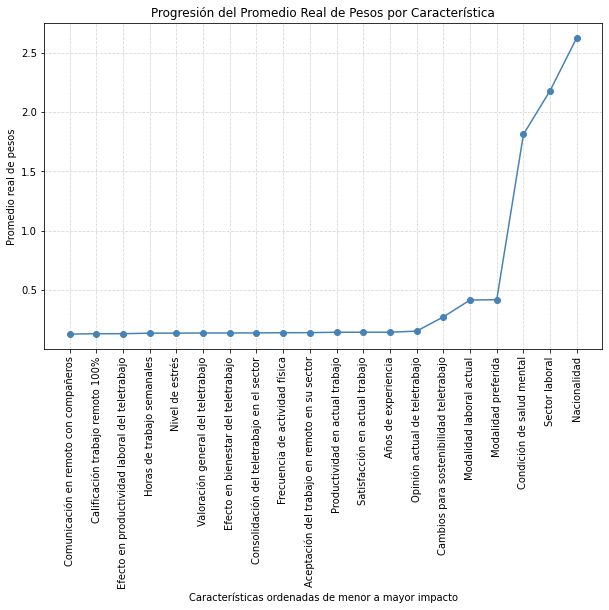

In [25]:
# Ordenar los valores de pesos agrupados de menor a mayor
pesos_ordenados = pesos_agrupados.sort_values(ascending=True)

plt.figure(figsize=(10, 6))

# Graficar la línea con los valores ordenados
plt.plot(pesos_ordenados.values, marker='o', linestyle='-', color='steelblue')

# Añadir etiquetas de características y título
plt.xticks(range(len(pesos_ordenados)), pesos_ordenados.index, rotation=90)
plt.xlabel("Características ordenadas de menor a mayor impacto")
plt.ylabel("Promedio real de pesos")
plt.title("Progresión del Promedio Real de Pesos por Característica")
plt.grid(True, linestyle="--", alpha=0.5)

# Mostrar el gráfico
plt.show()

In [26]:
# Crear un diccionario que mapea cada columna codificada a su variable original
mapeo_vars = {}

cols_codificadas = X.columns.tolist()

# Para OneHotEncoded: buscar las columnas que comienzan con cada variable original
for col in columnas_categoricas_onehotEncoding:
    prefijo = col + '_'
    for c in cols_caracteristicas:
        if c.startswith(prefijo):
            mapeo_vars[c] = col

# Para LabelEncoded: una columna corresponde a una variable
for col in columnas_categoricas_labelEncoding:
    if col in cols_caracteristicas:
        mapeo_vars[col] = col

# Para las demás columnas numéricas
for col in cols_caracteristicas:
    if col not in mapeo_vars:
        mapeo_vars[col] = col  # Se asignan a sí mismas

# Crear DataFrame con pesos
df_pesos = pd.DataFrame(
    pesos_entrada,
    index=cols_codificadas,
    columns=[f"Neurona_{j+1}" for j in range(pesos_entrada.shape[1])]
)

# Calcular el promedio de pesos absolutos por característica codificada
pesos = df_pesos.mean(axis=1)

# Agrupar por variable original
pesos_agrupados = pesos.groupby(mapeo_vars).sum().sort_values(ascending=True)

print("Promedio real de pesos en variables categóricas y numéricas (agrupadas por características):\n")
print(pesos_agrupados)

Promedio real de pesos en variables categóricas y numéricas (agrupadas por características):

Sector laboral                                    -0.033168
Modalidad laboral actual                          -0.016144
Condición de salud mental                         -0.013813
Cambios para sostenibilidad teletrabajo           -0.013357
Comunicación en remoto con compañeros             -0.012321
Nivel de estrés                                   -0.006849
Productividad en actual trabajo                   -0.005116
Frecuencia de actividad física                    -0.005084
Calificación trabajo remoto 100%                  -0.000912
Consolidación del teletrabajo en el sector         0.001039
Satisfacción en actual trabajo                     0.002393
Aceptación del trabajo en remoto en su sector      0.002740
Horas de trabajo semanales                         0.005122
Efecto en bienestar del teletrabajo                0.005362
Opinión actual de teletrabajo                      0.005446
Modali

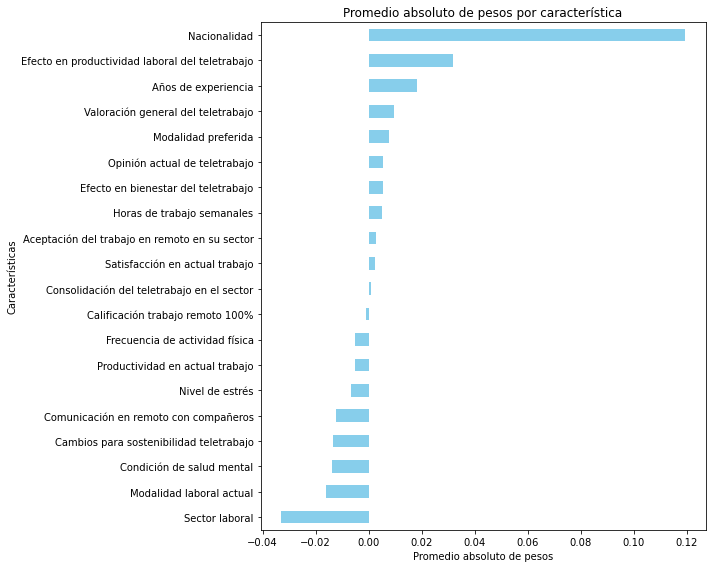

In [27]:
plt.figure(figsize=(10, 8))
# Graficar con barras horizontales (barh) usando la Serie 'pesos_agrupados', que ya está ordenada
pesos_agrupados.plot(kind="barh", color="skyblue")
plt.xlabel("Promedio absoluto de pesos")
plt.ylabel("Características")
plt.title("Promedio absoluto de pesos por característica")
plt.tight_layout()
plt.show()

In [28]:
print("Shape de y:", y.shape)
print("Shape de y_pred_classes:", y_pred_classes.shape)

Shape de y: (224,)
Shape de y_pred_classes: (141,)


### 7. Predicción de las modalidades laborales:

In [29]:
# Extraer la parte original de los datos antes de escalar y codificar
X_sin_etiqueta = df_inicial[df_inicial["Modalidad objetivo"] == -1]

# Asegurar que el índice coincida
df_pred["Modalidad laboral actual"] = X_sin_etiqueta["Modalidad laboral actual"].values

In [30]:
# Aplicar nuevamente las reglas para obtener una 'etiqueta estimada' a modo de referencia
df_pred["modalidad_esperada"] = df_pred.apply(aplicar_reglas, axis=1)

# Comparar la predicción del modelo contra esta 'modalidad esperada'
pd.crosstab(df_pred["modalidad_esperada"], df_pred["modalidad_predicha"], 
            rownames=["Esperada (reglas)"], colnames=["Predicción (modelo)"])

Predicción (modelo),0,1,2
Esperada (reglas),,,
-1,17,12,11
0,47,8,6
2,0,0,40


In [31]:
# Concatenar las predicciones con las columnas originales
df_resultado = pd.concat([X_sin_etiqueta.reset_index(drop=True), df_pred["modalidad_predicha"].reset_index(drop=True)], axis=1)

In [32]:
tabla_pct = pd.crosstab(df_resultado["Modalidad laboral actual"],
                        df_resultado["modalidad_predicha"],
                        normalize='index') * 100
tabla_pct = tabla_pct.round(2)

print(tabla_pct)

modalidad_predicha            0      1      2
Modalidad laboral actual                     
Híbrido                    0.00   0.00  100.0
Presencial                68.82  18.28   12.9
Remoto                     0.00  60.00   40.0


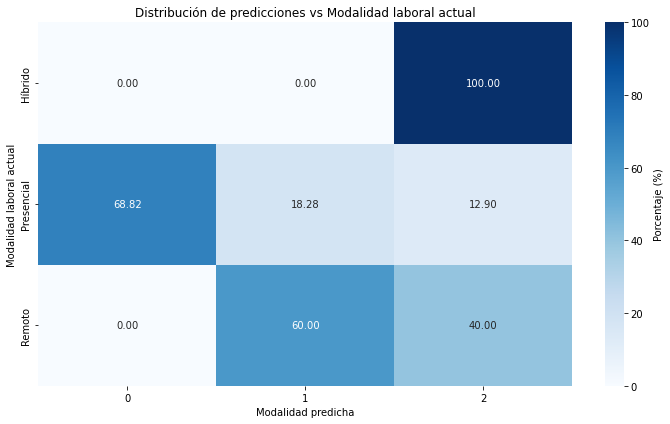

In [33]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(tabla_pct, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Porcentaje (%)'})
plt.title("Distribución de predicciones vs Modalidad laboral actual")
plt.ylabel("Modalidad laboral actual")
plt.xlabel("Modalidad predicha")
plt.tight_layout()
plt.show()